# Taxi

The Taxi problem involves navigating passengers in a grid world, picking them up and dropping them off at one of four locations (Red, Green, Yellow and Blue) in a 5x5 grid world. The taxi starts off at a random square and the passenger at one of the designated locations. The goal is move the taxi to the passenger’s location, pick up the passenger, move to the passenger’s desired destination, and drop off the passenger. Once the passenger is dropped off, the episode ends.

![](./images/taxi.png)

There is six possible actions. The agent can move to the four cardinal directions (south, north, east or west) and two other possible actions which are the pick-up or the drop-off:

- 0: Move south (down)
- 1: Move north (up)
- 2: Move east (right)
- 3: Move west (left)
- 4: Pickup passenger
- 5: Drop off passenger

The state is described by the taxi location on the grid (a row and a column number between 0 and 4), a location to drop-off the passenger from four choices, and the passenger which can be in one of the four locations or inside the taxi, in total 500 discrete states. An observation is returned as an int that encodes the corresponding state, calculated by: 
((taxi_row * 5 + taxi_col) * 5 + passenger_location) * 4 + destination

The player receives positive rewards for successfully dropping-off the passenger at the correct location. Negative rewards for incorrect attempts to pick-up/drop-off passenger and for each step where another reward is not received.

1 - Import the 'Taxi-v3' grid word from Gymnasium:

In [1]:
# You can get the environment from Gymnasium in the same way we got 'Frozen Lake’; 
# in order to visually plot the environment you can import it 
# using render_mode="rgb_array"

import gymnasium as gym
taxi = gym.make('Taxi-v3', render_mode="rgb_array")

2- Create a random policy as a baseline:

In [2]:
# You have to create a function that get in input a state and provide a random action
# (in the range [0;5])

import numpy as np

def pi_random(s):
    return np.random.choice(tuple(taxi.unwrapped.P[0].keys()));

3 - Show the policy in action by rendering the environment several times after different decisions from the random policy:

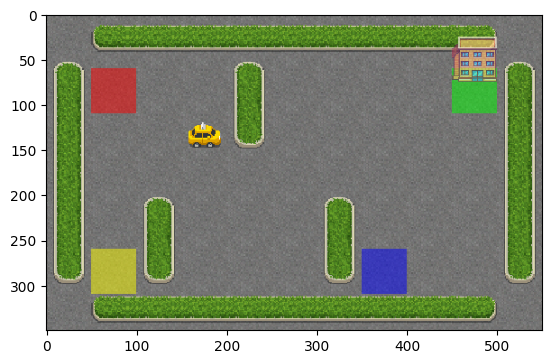

Step : 50 Action:  2


In [3]:
# You have to use a while loop in order to provide the current state to 
# the policy and then make a step in the environment using the action 
# provided by the policy. 
# Try to create a function (to be called "show_policy") 
# to be reused with other policies later.
# Hints: env.render() provides you an array representing 
# an image of the environment; plt.imshow() can be used to visualize 
# the image on the screen.

import time
import matplotlib.pyplot as plt
from IPython.display import clear_output

def show_policy(env, pi, n_episodes=1, max_steps=50):
    for _ in range(n_episodes):
        state, info = env.reset()
        done = False
        steps = 0;
        while not done and steps < max_steps:
            action = pi(state);
            state, reward, terminated, truncated, info = env.step(action)
            if(terminated or truncated):
                done = True;
            clear_output(wait=True)
            plt.imshow(env.render())
            plt.show()
            steps += 1
            print('Step :',steps, 'Action: ', action)
            time.sleep(0.5)

show_policy(taxi, pi_random)

2 - Write a brute-force function in order to evaluate the probability of success and the average return obtained by a policy, the evaluate the random policy:

In [4]:
# You can reuse the "evaluate" function that we already apply to 
# the Frozen Lake environment, however pay attention on how to determine 
# the end of an episode (it is no more state 15). 
# Hints: you have the "done" information from step function.

def evaluate(env, pi, n_episodes=10000):
    success = 0;
    returns = []
    for _ in range(n_episodes):
        done = False;
        steps = 0;
        state, info = env.reset();
        returns.append(0.0)
        while not done:
            state, reward, terminated, truncated, info = env.step(pi(state))
            if(terminated or truncated):
                done = True;
            returns[-1] += reward;
            steps += 1;
        if terminated:
            success += 1;
    return (success/n_episodes)*100, np.mean(returns);

probability_success, mean_return = evaluate(taxi, pi_random);

print("Reaches goal ", probability_success, "%");
print("Obtains an average undiscounted return of ", mean_return);

Reaches goal  4.79 %
Obtains an average undiscounted return of  -769.7887


3 - Use the value-iteration (or the policy-iteration) algorithm to calculate the optimal policy and also the optimal state-value function:

In [5]:
# You can reuse the "value_iteration" function or 
# the "policy_iteration” function that we already 
# apply to the Frozen Lake environment.

def value_iteration(env, gamma=1.0, theta=1e-10):

    # we need to unwrap the environment to access its 
    # internal dynamic
    dynamics = env.unwrapped.P;
    
    # initialize a state-value function
    v = np.zeros(len(dynamics))
    
    while True:
        q = np.zeros((len(dynamics), len(dynamics[0])))
        
        # for every transition of every action in every state, we...
        for s in range(len(dynamics)):
            for a in range(len(dynamics[s])):
                for prob, next_state, reward, done in dynamics[s][a]:    
                    # ...calculate the action-value function
                    q[s][a] += prob * (reward + gamma * v[next_state])
        
        # After each sweep over the state space, make sure the state-value function keeps changing, 
        # otherwise, we found the optimal state-value function and should break out
        if np.max(np.abs(v - np.max(q, axis=1))) < theta:
            break;
            
        # we don’t need a separate policy-improvement phase
        v = np.max(q, axis=1)
    
    # only at the end, we extract the optimal policy
    def pi(s):
        return np.argmax(q[s])  

    return v, pi

v_best, pi_best = value_iteration(taxi, gamma=0.99)

4 - Calculate the performance of the obtained optimal policy using the brute force approach:

In [6]:
# You can reuse the "evaluation" function written before, 
# in order to evaluate the optimal policy

probability_success, mean_return = evaluate(taxi, pi_best);
print("Reaches goal ", probability_success, "%");
print("Obtains an average undiscounted return of ", mean_return);

Reaches goal  100.0 %
Obtains an average undiscounted return of  7.9475


5  - Show the optimal policy:

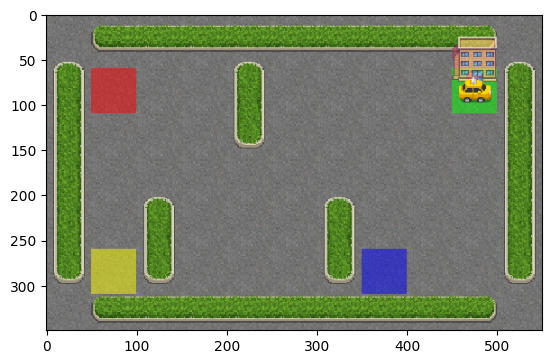

Step : 15 Action:  5


In [8]:
# You can reuse the "show_policy" function written before, 
# in order to show the optimal policy

show_policy(taxi, pi_best, n_episodes=3)